In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [4]:
df1=pd.read_excel('bonjean.xlsx',index_col=0)
df2=df1.transpose()
index=[float(i[3:]) for i in df2.index]
centre_index=[(10-k) for k in index]
col=[float(i[2:]) for i in df2.columns]

index_dict=dict(zip(df2.index,index))
cols_dict=dict(zip(df2.columns,col))

df_areas=df2.rename(index=index_dict,columns=cols_dict)

df3=pd.read_excel('offset.xlsx')
df4=df3.transpose()
df_offset=df4.drop(columns=0)
df_offset.head()



,1,2,3,4,5,6,7,8
0.0,0.00,0.00,0.00,0.00,0.00,0.17,0.42,0.85
0.5,0.00,0.00,0.25,0.42,0.59,0.85,1.27,1.94
1.0,0.02,0.34,0.68,0.93,1.27,1.69,2.20,3.04
1.5,0.51,0.86,1.27,1.61,2.03,2.45,3.13,4.06
2.0,1.10,1.41,2.11,2.37,2.87,3.38,4.14,4.99


In [5]:
df_areas.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.833333,18.333333,47.833333
0.5,0.000000,0.000000,4.166667,23.666667,46.166667,84.166667,133.833333,215.333333
1.0,0.000000,7.000000,33.583333,73.500000,128.083333,201.833333,298.583333,427.333333
1.5,18.625000,52.500000,105.625000,178.333333,267.958333,381.333333,517.291667,698.500000
2.0,47.458333,110.166667,194.958333,313.833333,435.958333,601.000000,778.125000,1016.500000


In [6]:
def area_method(stn_spacing, *offset):
    count = 0
    for i in range(len(offset)):
        
        if i == 0 or i ==24:
            count += 0.5*offset[i]
        
        elif i== 2 or i==22:
            count += offset[i]

        elif i==4 or i==18:
            count += offset[i] * 1.5
            
        elif i>=5 and i<=19 and i%2==1:
            count+=offset[i]*4
            
        else:
            count += offset[i] * 2
            
    return (count * 2 * stn_spacing) / 3

def hydros_prop(draft,stn_spacing):
    
    def wl_offsets():
        wl_offset_list=[i for i in df_offset.iloc[:,draft-1]]
        return wl_offset_list
        
    def wl_moments():
        wl_moment_list=[]
        l=0
        for i in df_offset.iloc[:,draft-1]:
            k=index[l]
            wl_moment_list.append(i*stn_spacing*(10-k))
            l+=1
        return wl_moment_list       
    
    def areas():
        areas_list=[i for i in df_areas.iloc[:,draft-1]]
        return areas_list    
    
    def area_moments():
        area_moment_list=[]
        l=0
        
        for i in df_areas.iloc[:,draft-1]:
            k=index[l]
            area_moment_list.append(i*stn_spacing*(10-k))
            l+=1
        return area_moment_list
        
    def displ():  
        return area_method(stn_spacing,*areas())
    
    def aw():
        return area_method(stn_spacing,*wl_offsets())

    def mass_displ():
        return 1.025*displ()
    
    def tpc():
        return aw()*1.025/100
    
    
    def form_coeffs(L,B):
        def cb():
            return displ()/(L*B*draft)
            
        def cp():
            return displ()/(df_areas.iloc[12,draft-1]*L)
        
        def cm():
            return df_areas.iloc[12,draft-1]/(B*draft)
        
        def cw():
            return aw()/(L*B)
        
        return cb,cp,cm,cw
    
    def lcb():
        return area_method(stn_spacing,*area_moments())/area_method(stn_spacing,*areas())
    
    
    def lcf():
        return area_method(stn_spacing,*wl_moments())/area_method(stn_spacing,*wl_offsets())
    
    def il():
        long_moi_centre=map(lambda x,y: y*(x**2),centre_index,wl_offsets())
        long_moi_lcf=area_method(stn_spacing,*long_moi_centre)-(aw()*(lcf()**2))
        return long_moi_lcf
    
    def it():
        trans_moi=map(lambda y:y**3,wl_offsets())
        return area_method(stn_spacing,*trans_moi)/3
    
    def bml():
        return il()/displ()
    
    def bmt():
        return it()/displ()
    
    def mctc(L):
        return (mass_displ()*bml())/(100*L)
    
    
    return wl_offsets,wl_moments,areas,area_moments,displ,aw,mass_displ,tpc,lcb,lcf,il,it,bml,bmt,mctc,form_coeffs



In [7]:
areas_list=[i for i in df_areas.iloc[:,7]]
areas_list

[47.83333333333334,
 215.3333333333333,
 427.3333333333333,
 698.5,
 1016.5,
 1668.666666666667,
 2282.5,
 2750.833333333333,
 3070.666666666666,
 3234.833333333334,
 3307.166666666667,
 3341.5,
 3348.166666666667,
 3358.166666666667,
 3356.666666666667,
 3348.5,
 3277.5,
 3093.666666666667,
 2780.333333333333,
 2328.666666666667,
 1770.833333333333,
 1462.833333333333,
 1142.0,
 821.1666666666666,
 585.8333333333334]

In [11]:
stn_spacing=float(input("enter station spacing: "))
length=float(input('enter length: '))
breadth=float(input('enter breadth:'))
hydros_list=[]
draft=1

for i in range(len(df_areas.columns)):
    wl_offsets,wl_moments,areas,area_moments,displ,aw,mass_displ,tpc,lcb,lcf,il,it,bml,bmt,mctc,form_coeffs=hydros_prop(draft,stn_spacing)
    cb,cp,cm,cw=form_coeffs(length,breadth)
    hydros_list.append([displ(),aw(),mass_displ(),tpc(),lcb(),lcf(),il(),it(),bml(),bmt(),mctc(length),cb(),cp(),cm(),cw()])
    draft+=1

rounded_hydros_list=[[round(j,3) for j in i] for i in hydros_list]  
waterlines=list(range(1,len(df_offset.columns)+1)) 
df_cols=[f'wl{i}' for i in waterlines]
hydros_dict=dict(zip(df_cols,rounded_hydros_list))

hydros_names=['Displacement','Aw','Mass Displacement','TPC','LCB','LCF','IL','IT','BML','BMT','MCTC','CB','CP','CM','CW']
index_dict=dict(zip(list(range(15)),hydros_names))


df0=pd.DataFrame(hydros_dict)
df_hydros=df0.rename(index=index_dict)
df_hydros.to_excel('Hydrostatics.xlsx')

df_hydros

enter station spacing: 25
enter length: 200
enter breadth:20


,wl1,wl2,wl3,wl4,wl5,wl6,wl7,wl8
Displacement,238997.917,499975.000,783095.139,1081179.167,1395095.139,1730851.389,2084411.806,2455056.944
Aw,4991.417,5456.500,5829.167,6099.083,6494.500,6903.250,7251.500,7543.083
Mass Displacement,244972.865,512474.375,802672.517,1108208.646,1429972.517,1774122.674,2136522.101,2516433.368
TPC,51.162,55.929,59.749,62.516,66.569,70.758,74.328,77.317
LCB,-12.710,-11.288,-9.848,-8.826,-9.186,-10.335,-11.854,-12.901
LCF,-11.361,-8.644,-5.988,-7.725,-12.765,-17.674,-19.668,-17.847
IL,-563743.099,-314476.384,-99692.527,-241705.433,-912161.487,-1984014.876,-2609406.231,-2187777.562
IT,81730.469,99670.048,109635.715,117727.446,127184.374,138908.901,150895.829,161699.296
BML,-2.359,-0.629,-0.127,-0.224,-0.654,-1.146,-1.252,-0.891
BMT,0.342,0.199,0.140,0.109,0.091,0.080,0.072,0.066


In [47]:
displ,aw,mass_displ,tpc,lcb,lcf,il,it,bml,bmt,mctc,cb,cp,cm,cw=([] for i in range(15))
hydros_list=[displ,aw,mass_displ,tpc,lcb,lcf,il,it,bml,bmt,mctc,cb,cp,cm,cw]

def limit_value(x,lim):
    for i in x:
        x=(x*lim)/(max(x)-min(x))
    
    
k=0
for i in range(len(df_hydros.index)):
    for j in range(len(df_hydros.columns)):
        hydros_list[k].append(df_hydros.iloc[i,j])
    k+=1
    if k==15:
        break
        
len(waterlines)


8

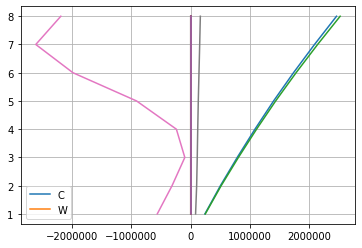

In [88]:

for l in range(len(hydros_list)):
        plt.plot(hydros_list[l],waterlines)
        plt.legend(f'{df_hydros.index[l]}')
        plt.grid()
    
    
    
    

        
   
    
    



In [92]:




def limit_value(x,lim1,lim2):
    for n,i in enumerate(x):
        

    return x
        
        
x=limit_value([100,80,-100],0,5)
x

[100, 80, -100]

In [93]:
ls=list(range(5))


SyntaxError: invalid syntax (<ipython-input-93-fa5f1e019465>, line 3)